# Clustering and Visualizing High Dimensional Data 

## Dataset

**Title:** Forest Cover Type Dataset 

**Description:** Tree types found in the Roosevelt National Forest in Colorado

**Context:** This dataset contains tree observations from four areas of the Roosevelt National Forest in Colorado. All observations are cartographic variables (no remote sensing) from 30 meter x 30 meter sections of forest. There are over half a million measurements total).

**Content:** This dataset includes information on tree type, shadow coverage, distance to nearby landmarks (roads etcetera), soil type, and local topography. 

**Acknowledgement:** This dataset is part of the UCI Machine Learning Repository, and the original source can be found here. The original database owners are Jock A. Blackard, Dr. Denis J. Dean, and Dr. Charles W. Anderson of the Remote Sensing and GIS Program at Colorado State University.

**URL:** https://www.kaggle.com/uciml/forest-cover-type-dataset

## Implementation

First we need to import all the necessary libraries

In [1]:
#Basic imports
import numpy as np
import pandas as pd

#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'
from sklearn.metrics import silhouette_score

#metric visualizer imports
from yellowbrick.cluster import SilhouetteVisualizer

#plotly imports
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

### Configuration Constants

In [105]:
RAND_SAMPLE_SIZE = 100000
RAND_SAMPLE_SIZE_PCA = 25000
RAND_SAMPLE_SIZE_TSNE = 1000

N_CLUSTERS = 3

PERPLEXITY = 50

Now, let's import the dataset

In [3]:
df = pd.read_csv("data/covtype.csv")

Before proceeding, we have to make a clone of the dataframe. Then we need to check whether if there are any missing values as follows.

#### Preprocessing

In [4]:
X = df.copy()
X.isnull().sum()

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


Since there are no missing values, we can proceed examine the dataset a bit.

There are 581,012 entries and 55 attributes. Among them, 10 are numerical and 45 is categorical. The categorical variable 'Cover_Type' is currently assigned with integers which represents the following cover types according to https://archive.ics.uci.edu/ml/datasets/Covertype
    1. Spruce/Fir
    2. Lodgepole Pine
    3. Ponderosa Pine
    4. Cottonwood/Willow
    5. Aspen
    6. Douglas-fir
    7. Krummholz

In [5]:
X.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


If we were to do clustering this is will be considered as a high dimensional set of data as the no.of dimensions are greater than 3. 

To calculate the distance between two points within a spacial space of 55 dimensions is possible but difficult for the algorithms.

Also, some of the dimensions have values in ranges varying from tens to hundreds to thousands. So, distance calculations using these values will only hinder the performance of the clustering algorithm.

Therefore, we need to normalize the data attributes and then apply dimensionality reduction techniques before going in for clustering.

In [6]:
X[["Elevation","Aspect","Slope","Horizontal_Distance_To_Roadways","Hillshade_9am","Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points","Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"]].describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,2350.146611,212.146049,223.318716,142.528263,1980.291226,269.428217,46.418855
std,279.984734,111.913721,7.488242,1559.254870,26.769889,19.768697,38.274529,1324.195210,212.549356,58.295232
min,1859.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-173.000000
25%,2809.000000,58.000000,9.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,108.000000,7.000000
50%,2996.000000,127.000000,13.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,218.000000,30.000000
75%,3163.000000,260.000000,18.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,384.000000,69.000000
max,3858.000000,360.000000,66.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,1397.000000,601.000000


When we observe the numerical attribute, we can see that we don't need the following two separate variables.
  - Horizontal_Distance_To_Hydrology
  - Vertical_Distance_To_Hydrology

We can combine them into one attribute and remove the above two as follows.

In [7]:
X["Distance_To_Hydrology"] = ( (X["Horizontal_Distance_To_Hydrology"] ** 2) + (X["Vertical_Distance_To_Hydrology"] ** 2) ) ** (0.5)

In [8]:
X.drop(["Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"], axis=1, inplace=True)

In order to one-hot-encode the 'Cover_Type' attribute, let's add its corresponding class labels as follows and then do the one-hot-encoding.

In [9]:
X['Cover_Type'].replace({1:'Spruce/Fir', 2:'Lodgepole Pine', 3:'Ponderosa Pine', 4:'Cottonwood/Willow', 5:'Aspen', 6:'Douglas-fir', 7:'Krummholz'}, inplace=True)

In [10]:
X = pd.get_dummies(X, columns=['Cover_Type'])

#### Normalization

Let's divide the data set into numerical and categorical attributes before doing the normalization as follows.

In [11]:
numerical = X[["Elevation","Aspect","Slope","Horizontal_Distance_To_Roadways","Hillshade_9am","Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points","Distance_To_Hydrology"]]
categorical = X[["Wilderness_Area1","Wilderness_Area2","Wilderness_Area3","Wilderness_Area4","Soil_Type1","Soil_Type2","Soil_Type3","Soil_Type4","Soil_Type5","Soil_Type6","Soil_Type7","Soil_Type8","Soil_Type9","Soil_Type10","Soil_Type11","Soil_Type12","Soil_Type13","Soil_Type14","Soil_Type15","Soil_Type16","Soil_Type17","Soil_Type18","Soil_Type19","Soil_Type20","Soil_Type21","Soil_Type22","Soil_Type23","Soil_Type24","Soil_Type25","Soil_Type26","Soil_Type27","Soil_Type28","Soil_Type29","Soil_Type30","Soil_Type31","Soil_Type32","Soil_Type33","Soil_Type34","Soil_Type35","Soil_Type36","Soil_Type37","Soil_Type38","Soil_Type39","Soil_Type40","Cover_Type_Aspen","Cover_Type_Cottonwood/Willow","Cover_Type_Douglas-fir","Cover_Type_Krummholz","Cover_Type_Lodgepole Pine","Cover_Type_Ponderosa Pine","Cover_Type_Spruce/Fir"]]

Now we can do the normalization.

In [12]:
sc = StandardScaler()
numerical = pd.DataFrame(sc.fit_transform(numerical))
numerical.columns = ["Elevation_Scaled","Aspect_Scaled","Slope_Scaled","Horizontal_Distance_To_Roadways_Scaled","Hillshade_9am_Scaled","Hillshade_Noon_Scaled","Hillshade_3pm_Scaled","Horizontal_Distance_To_Fire_Points_Scaled","Distance_To_Hydrology_Scaled"]

Now we can rejoin the two variable sets together to make the full dataset.

In [13]:
X = pd.concat([numerical, categorical], axis=1, join='inner')
X.head()

,Elevation_Scaled,Aspect_Scaled,Slope_Scaled,Horizontal_Distance_To_Roadways_Scaled,Hillshade_9am_Scaled,Hillshade_Noon_Scaled,Hillshade_3pm_Scaled,Horizontal_Distance_To_Fire_Points_Scaled,Distance_To_Hydrology_Scaled,Wilderness_Area1,...,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type_Aspen,Cover_Type_Cottonwood/Willow,Cover_Type_Douglas-fir,Cover_Type_Krummholz,Cover_Type_Lodgepole Pine,Cover_Type_Ponderosa Pine,Cover_Type_Spruce/Fir
0,-1.297805,-0.935157,-1.482820,-1.180146,0.330743,0.439143,0.142960,3.246283,-0.083233,1,...,0,0,0,1,0,0,0,0,0,0
1,-1.319235,-0.890480,-1.616363,-1.257106,0.293388,0.590899,0.221342,3.205504,-0.294777,1,...,0,0,0,1,0,0,0,0,0,0
2,-0.554907,-0.148836,-0.681563,0.532212,0.816364,0.742654,-0.196691,3.126965,-0.001362,1,...,0,0,0,0,0,0,0,1,0,0
3,-0.622768,-0.005869,0.520322,0.474492,0.965786,0.742654,-0.536343,3.194931,-0.031466,1,...,0,0,0,0,0,0,0,1,0,0
4,-1.301377,-0.988770,-1.616363,-1.256464,0.293388,0.540313,0.195215,3.165479,-0.566983,1,...,0,0,0,1,0,0,0,0,0,0


Now let's start applying the following dimensionality reduction methods for the dataset X.
    1. PCA - Principle Component Analysis
    2. TSNE - T-distributed Stochastic Neighbor Embedding

#### Dimensionality Reduction using PCA

Let's create one, two and three principle components respectively as follows.

In [14]:
pca_1d = PCA(n_components=1)

pca_2d = PCA(n_components=2)

pca_3d = PCA(n_components=3)

Since PCA takes long time to compute, random sample of `RAND_SAMPLE_SIZE_PCA` entries are taken from X for the T-SNE section.

In [15]:
X_PCA_sub = pd.DataFrame(np.array(X.sample(RAND_SAMPLE_SIZE_PCA)))
X_PCA_sub.columns = X.columns

In [16]:
PCs_1d = pd.DataFrame(pca_1d.fit_transform(X_PCA_sub))

PCs_2d = pd.DataFrame(pca_2d.fit_transform(X_PCA_sub))

PCs_3d = pd.DataFrame(pca_3d.fit_transform(X_PCA_sub))

Renaming the columns as Principle Components accordingly.

In [17]:
PCs_1d.columns = ["PC1_1d"]
PCs_2d.columns = ["PC1_2d", "PC2_2d"]
PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]

#### Dimensionality Reduction using T-SNE

In [18]:
tsne_1d = TSNE(n_components=1, perplexity=PERPLEXITY)

tsne_2d = TSNE(n_components=2, perplexity=PERPLEXITY)

tsne_3d = TSNE(n_components=3, perplexity=PERPLEXITY)

Since T-SNE takes long time to compute, random sample of `RAND_SAMPLE_SIZE_TSNE` entries are taken from X for the T-SNE section.

In [19]:
X_TSNE_sub = pd.DataFrame(np.array(X.sample(RAND_SAMPLE_SIZE_TSNE)))
X_TSNE_sub.columns = X.columns

In [20]:
# TCs_1d = pd.DataFrame(tsne_1d.fit_transform(X))
TCs_1d = pd.DataFrame(tsne_1d.fit_transform(X_TSNE_sub))

# TCs_2d = pd.DataFrame(tsne_2d.fit_transform(X))
TCs_2d = pd.DataFrame(tsne_2d.fit_transform(X_TSNE_sub))

# TCs_3d = pd.DataFrame(tsne_3d.fit_transform(X))
TCs_3d = pd.DataFrame(tsne_3d.fit_transform(X_TSNE_sub))

In [21]:
TCs_1d.columns = ["TC1_1d"]
TCs_2d.columns = ["TC1_2d","TC2_2d"]
TCs_3d.columns = ["TC1_3d","TC2_3d","TC3_3d"]

### Clustering based on Principle Components

In [22]:
kmeans_PCA_1d = KMeans(n_clusters=N_CLUSTERS)
kmeans_PCA_2d = KMeans(n_clusters=N_CLUSTERS)
kmeans_PCA_3d = KMeans(n_clusters=N_CLUSTERS)

In [23]:
kmeans_PCA_1d.fit(PCs_1d)

KMeans(n_clusters=3)

In [24]:
kmeans_PCA_2d.fit(PCs_2d)

KMeans(n_clusters=3)

In [25]:
kmeans_PCA_3d.fit(PCs_3d)

KMeans(n_clusters=3)

In [26]:
clusters_PCA_1d = kmeans_PCA_1d.predict(PCs_1d)

In [27]:
clusters_PCA_2d = kmeans_PCA_2d.predict(PCs_2d)

In [28]:
clusters_PCA_3d = kmeans_PCA_3d.predict(PCs_3d)

In [29]:
PCs_1d_vis = PCs_1d.copy()

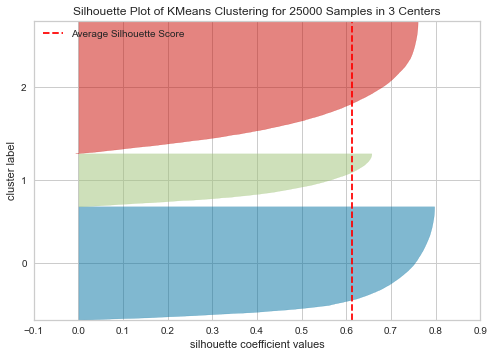

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 25000 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [30]:
visualizer_PCA_1d = SilhouetteVisualizer(kmeans_PCA_1d, colors='yellowbrick')
visualizer_PCA_1d.fit(PCs_1d_vis)        # Fit the data to the visualizer
visualizer_PCA_1d.show()

In [31]:
PCs_2d_vis = PCs_2d.copy()

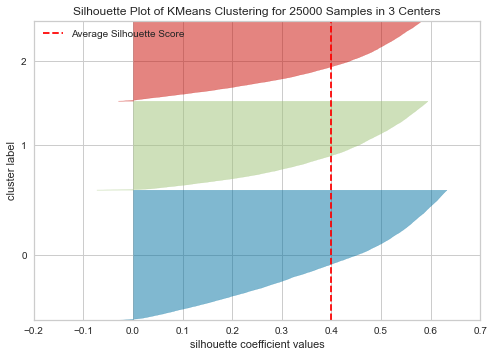

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 25000 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [32]:
visualizer_PCA_2d = SilhouetteVisualizer(kmeans_PCA_2d, colors='yellowbrick')
visualizer_PCA_2d.fit(PCs_2d_vis)        # Fit the data to the visualizer
visualizer_PCA_2d.show()

In [33]:
PCs_3d_vis = PCs_3d.copy()

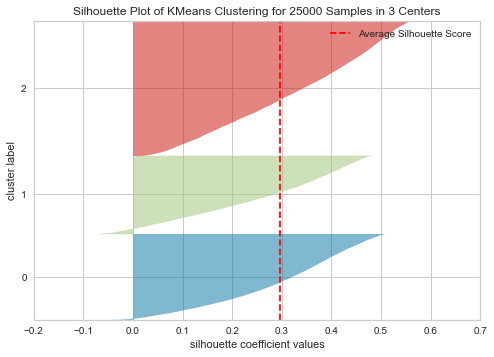

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 25000 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [34]:
visualizer_PCA_3d = SilhouetteVisualizer(kmeans_PCA_3d, colors='yellowbrick')
visualizer_PCA_3d.fit(PCs_3d_vis)        # Fit the data to the visualizer
visualizer_PCA_3d.show()

In [35]:
# visualizer_PCA_3d.fig.savefig("hello.png", dpi=720)

In [36]:
# PCs_1d["Cluster"] = clusters_PCA_1d
# PCs_2d["Cluster"] = clusters_PCA_2d
# PCs_3d["Cluster"] = clusters_PCA_3d

### Clustering based on T-SNE reduced dimensions

In [37]:
kmeans_TSNE_1d = KMeans(n_clusters=N_CLUSTERS)
kmeans_TSNE_2d = KMeans(n_clusters=N_CLUSTERS)
kmeans_TSNE_3d = KMeans(n_clusters=N_CLUSTERS)

In [38]:
kmeans_TSNE_1d.fit(TCs_1d)

KMeans(n_clusters=3)

In [39]:
kmeans_TSNE_2d.fit(TCs_2d)

KMeans(n_clusters=3)

In [40]:
kmeans_TSNE_3d.fit(TCs_3d)

KMeans(n_clusters=3)

In [41]:
clusters_TSNE_1d = kmeans_TSNE_1d.predict(TCs_1d)

In [42]:
clusters_TSNE_2d = kmeans_TSNE_2d.predict(TCs_2d)

In [43]:
clusters_TSNE_3d = kmeans_TSNE_3d.predict(TCs_3d)

In [44]:
TCs_1d_vis = TCs_1d.copy()

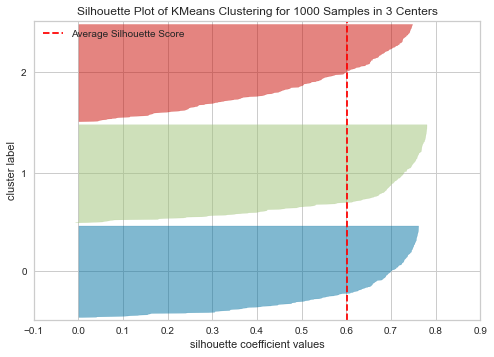

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1000 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [45]:
visualizer_TSNE_1d = SilhouetteVisualizer(kmeans_TSNE_1d, colors='yellowbrick')
visualizer_TSNE_1d.fit(TCs_1d_vis)        # Fit the data to the visualizer
visualizer_TSNE_1d.show()

In [46]:
TCs_2d_vis = TCs_2d.copy()

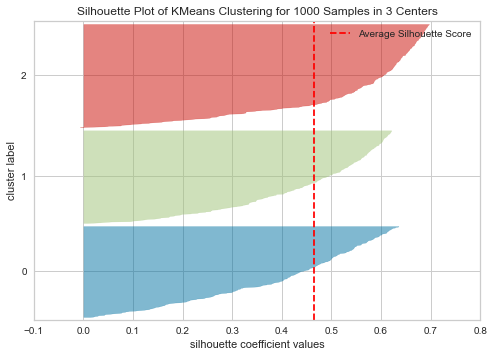

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1000 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [47]:
visualizer_TSNE_2d = SilhouetteVisualizer(kmeans_TSNE_2d, colors='yellowbrick')
visualizer_TSNE_2d.fit(TCs_2d_vis)        # Fit the data to the visualizer
visualizer_TSNE_2d.show()

In [48]:
TCs_3d_vis = TCs_3d.copy()

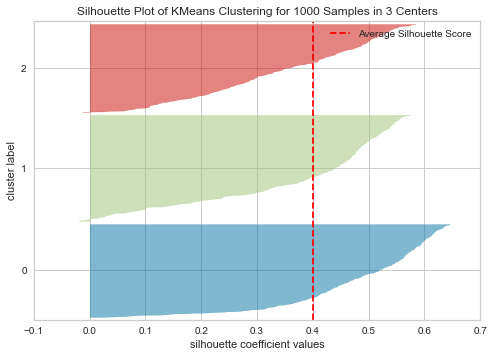

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1000 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [49]:
visualizer_TSNE_3d = SilhouetteVisualizer(kmeans_TSNE_3d, colors='yellowbrick')
visualizer_TSNE_3d.fit(TCs_3d_vis)        # Fit the data to the visualizer
visualizer_TSNE_3d.show()

In [50]:
# TCs_1d["Cluster"] = clusters_TSNE_1d
# TCs_2d["Cluster"] = clusters_TSNE_2d
# TCs_3d["Cluster"] = clusters_TSNE_3d

#### Clustering Evaluation

In [51]:
score_PCA_1d = silhouette_score(PCs_1d, kmeans_PCA_1d.labels_, metric='euclidean')

In [52]:
score_PCA_2d = silhouette_score(PCs_2d, kmeans_PCA_2d.labels_, metric='euclidean')

In [53]:
score_PCA_3d = silhouette_score(PCs_3d, kmeans_PCA_3d.labels_, metric='euclidean')

In [54]:
[score_PCA_1d, score_PCA_2d, score_PCA_3d]

[0.6121457504503075, 0.39857014703826993, 0.2970290708766904]

In [55]:
score_TSNE_1d = silhouette_score(TCs_1d, kmeans_TSNE_1d.labels_, metric='euclidean')

In [56]:
score_TSNE_2d = silhouette_score(TCs_2d, kmeans_TSNE_2d.labels_, metric='euclidean')

In [57]:
score_TSNE_3d = silhouette_score(TCs_3d, kmeans_TSNE_3d.labels_, metric='euclidean')

In [58]:
[score_TSNE_1d, score_TSNE_2d, score_TSNE_3d]

[0.6020122, 0.46400756, 0.39985064]

### Without Dimensionality Reduction

In [67]:
X_sub = pd.DataFrame(np.array(X.sample(RAND_SAMPLE_SIZE)))
X_sub.columns = X.columns

In [68]:
kmeans_sub = KMeans(n_clusters=N_CLUSTERS)

In [69]:
kmeans_sub.fit(X_sub)

KMeans(n_clusters=3)

In [70]:
clusters_sub = kmeans_sub.predict(X_sub)

In [71]:
X_sub["Cluster"] = clusters_sub

In [112]:
score_sub = silhouette_score(X_sub, kmeans_sub.labels_, metric='euclidean')
score_sub

0.18349100286500244

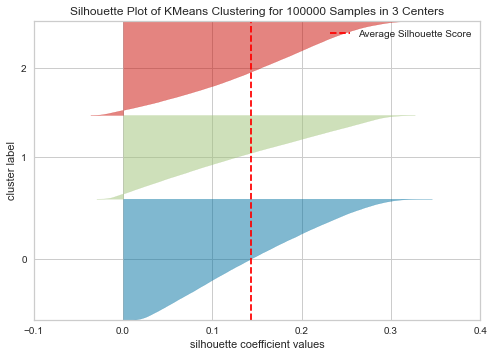

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 100000 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [113]:
visualizer_sub = SilhouetteVisualizer(kmeans_sub, colors='yellowbrick')
visualizer_sub.fit(X_sub.drop("Cluster", axis=1))        # Fit the data to the visualizer
visualizer_sub.show()        

### Plotting Clusters by PCA

In [87]:
plotX_PCA = pd.DataFrame(np.array(X_sub.sample(5000)))
plotX_PCA.columns = X_sub.columns

In [88]:
plotX_PCA = pd.concat([plotX_PCA, PCs_1d, PCs_2d, PCs_3d], axis=1, join='inner')

In [89]:
plotX_PCA["dummy"] = 0

In [92]:
cluster0 = plotX_PCA[plotX_PCA["Cluster"] == 0]
cluster1 = plotX_PCA[plotX_PCA["Cluster"] == 1]
cluster2 = plotX_PCA[plotX_PCA["Cluster"] == 2]

In [93]:
init_notebook_mode(connected=True)

In [94]:
#Instructions for building the 1-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1_1d"],
                    y = cluster0["dummy"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_1d"],
                    y = cluster1["dummy"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["PC1_1d"],
                    y = cluster2["dummy"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in One Dimension Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= '',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

In [95]:
#Instructions for building the 2-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1_2d"],
                    y = cluster0["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_2d"],
                    y = cluster1["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["PC1_2d"],
                    y = cluster2["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

In [96]:
#Instructions for building the 3-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter3d(
                    x = cluster0["PC1_3d"],
                    y = cluster0["PC2_3d"],
                    z = cluster0["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter3d(
                    x = cluster1["PC1_3d"],
                    y = cluster1["PC2_3d"],
                    z = cluster1["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter3d(
                    x = cluster2["PC1_3d"],
                    y = cluster2["PC2_3d"],
                    z = cluster2["PC3_3d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Three Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

### Plotting Clusters by T-SNE

In [99]:
plotX_TSNE = pd.DataFrame(np.array(X_sub.sample(5000)))
plotX_TSNE.columns = X_sub.columns

In [100]:
plotX_TSNE = pd.concat([plotX_TSNE, TCs_1d, TCs_2d, TCs_3d], axis=1, join='inner')

In [101]:
plotX_TSNE["dummy"] = 0

In [102]:
cluster0 = plotX_TSNE[plotX_TSNE["Cluster"] == 0]
cluster1 = plotX_TSNE[plotX_TSNE["Cluster"] == 1]
cluster2 = plotX_TSNE[plotX_TSNE["Cluster"] == 2]

In [103]:
init_notebook_mode(connected=True)

In [106]:
#Instructions for building the 1-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["TC1_1d"],
                    y = cluster0["dummy"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["TC1_1d"],
                    y = cluster1["dummy"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["TC1_1d"],
                    y = cluster2["dummy"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in One Dimension Using T-SNE (perplexity=" + str(PERPLEXITY) + ")"

layout = dict(title = title,
              xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= '',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

In [109]:
#Instructions for building the 2-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["TC1_2d"],
                    y = cluster0["TC2_2d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["TC1_2d"],
                    y = cluster1["TC2_2d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["TC1_2d"],
                    y = cluster2["TC2_2d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Two Dimensions Using T-SNE (perplexity=" + str(PERPLEXITY) + ")"

layout = dict(title = title,
              xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'TC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

In [110]:
#Instructions for building the 3-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter3d(
                    x = cluster0["TC1_3d"],
                    y = cluster0["TC2_3d"],
                    z = cluster0["TC3_3d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter3d(
                    x = cluster1["TC1_3d"],
                    y = cluster1["TC2_3d"],
                    z = cluster1["TC3_3d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter3d(
                    x = cluster2["TC1_3d"],
                    y = cluster2["TC2_3d"],
                    z = cluster2["TC3_3d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Three Dimensions Using T-SNE (perplexity=" + str(PERPLEXITY) + ")"

layout = dict(title = title,
              xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'TC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)